In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


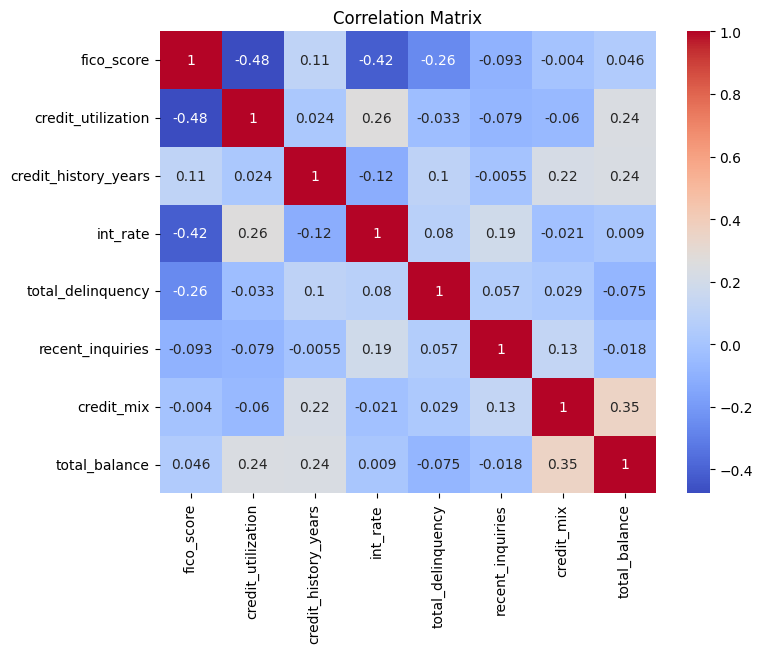

In [2]:
df = pd.read_csv("../data/processed/accepted_cleaned.csv")
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [3]:
def train_ols_model(csv_path: str):
    df = pd.read_csv(csv_path)

    features = [
        'credit_utilization', 'credit_history_years',
        'total_delinquency', 'recent_inquiries',
        'credit_mix', 'total_balance'
    ]
    X = df[features]
    y = df['fico_score']

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    y_pred = model.predict(X)

    print(model.summary())
    print("\nMAE:", mean_absolute_error(y, y_pred))
    print("R²:", r2_score(y, y_pred))
train_ols_model("../data/processed/accepted_cleaned.csv")

                            OLS Regression Results                            
Dep. Variable:             fico_score   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                 2.125e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        15:03:11   Log-Likelihood:            -1.0598e+07
No. Observations:             2258866   AIC:                         2.120e+07
Df Residuals:                 2258859   BIC:                         2.120e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  735.4541 

In [4]:
def train_ols_with_scaling(csv_path: str):
    df = pd.read_csv(csv_path)

    features = ['credit_utilization', 'credit_history_years',
                'total_delinquency', 'recent_inquiries',
                'credit_mix', 'total_balance']
    X = df[features]
    y = df['fico_score']

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features)

    # Add intercept manually (statsmodels)
    X_scaled = sm.add_constant(X_scaled)

    # Fit model
    model = sm.OLS(y, X_scaled).fit()
    y_pred = model.predict(X_scaled)

    # Evaluation
    print(model.summary())
    print("\nMAE:", mean_absolute_error(y, y_pred))
    print("R²:", r2_score(y, y_pred))
train_ols_with_scaling("../data/processed/accepted_cleaned.csv")

                            OLS Regression Results                            
Dep. Variable:             fico_score   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                 2.125e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        15:03:14   Log-Likelihood:            -1.0598e+07
No. Observations:             2258866   AIC:                         2.120e+07
Df Residuals:                 2258859   BIC:                         2.120e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  700.5802 

In [5]:


def remove_outliers_zscore(df, features, threshold=3):
    z_scores = np.abs(zscore(df[features]))
    mask = (z_scores < threshold).all(axis=1)
    df_clean = df[mask]
    print(f"Outlier Removal: {len(df)} → {len(df_clean)} rows retained")
    return df_clean

def train_ols(csv_path: str):
    # Step 1: Load dataset
    df = pd.read_csv(csv_path)

    # Step 2: Select features and target
    features = ['credit_utilization', 'credit_history_years',
                'total_delinquency', 'recent_inquiries',
                'credit_mix', 'total_balance']
    target = 'fico_score'

    # Step 3: Outlier Removal
    df_clean = remove_outliers_zscore(df, features)

    # Step 4: Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[features])
    X_scaled = pd.DataFrame(X_scaled, columns=features, index=df_clean.index)
    X_scaled = sm.add_constant(X_scaled)


    y = df_clean[target]

    # Step 5: OLS Regression
    model = sm.OLS(y, X_scaled).fit()
    y_pred = model.predict(X_scaled)

    # Step 6: Print results
    print(model.summary())
    print(f"\nMAE: {mean_absolute_error(y, y_pred):.4f}")
    print(f"R²: {r2_score(y, y_pred):.4f}")

    return model, scaler
train_ols("../data/processed/accepted_cleaned.csv")


Outlier Removal: 2258866 → 2114622 rows retained
                            OLS Regression Results                            
Dep. Variable:             fico_score   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 2.338e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        15:03:17   Log-Likelihood:            -9.8580e+06
No. Observations:             2114622   AIC:                         1.972e+07
Df Residuals:                 2114615   BIC:                         1.972e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2375c82dbe0>,
 StandardScaler())

In [6]:


def remove_outliers_zscore(df, features, threshold=3):
    z_scores = np.abs(zscore(df[features]))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]

def train_ols_with_log_transform(csv_path: str):
    df = pd.read_csv(csv_path)

    # Log-transform the skewed feature
    df['log_total_balance'] = np.log1p(df['total_balance'])

    # Define features (replace original total_balance)
    features = ['credit_utilization', 'credit_history_years',
                'total_delinquency', 'recent_inquiries',
                'credit_mix', 'log_total_balance']

    # Remove outliers (on transformed features too)
    df_clean = remove_outliers_zscore(df, features)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[features])
    X_scaled = pd.DataFrame(X_scaled, columns=features, index=df_clean.index)
    X_scaled = sm.add_constant(X_scaled)

    y = df_clean['fico_score']

    # Fit OLS
    model = sm.OLS(y, X_scaled).fit()
    y_pred = model.predict(X_scaled)

    print(model.summary())
    print(f"\nMAE: {mean_absolute_error(y, y_pred):.4f}")
    print(f"R²: {r2_score(y, y_pred):.4f}")

    return model, df_clean

model, df_clean = train_ols_with_log_transform("../data/processed/accepted_cleaned.csv")


                            OLS Regression Results                            
Dep. Variable:             fico_score   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 2.382e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        15:03:23   Log-Likelihood:            -9.8888e+06
No. Observations:             2123416   AIC:                         1.978e+07
Df Residuals:                 2123409   BIC:                         1.978e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  700.9217 

In [10]:
def remove_outliers(df, features, threshold=3):
    # Drop rows with NaNs in the selected features before z-scoring
    df_clean = df.dropna(subset=features).copy()
    
    # Compute Z-scores and filter out rows with any feature beyond the threshold
    z_scores = np.abs(zscore(df_clean[features]))
    mask = (z_scores < threshold).all(axis=1)
    return df_clean[mask]

def train_ridge_model(csv_path: str, alpha=1.0):
    df = pd.read_csv(csv_path)

    # Ensure log_total_balance exists
    if 'log_total_balance' not in df.columns:
        df['log_total_balance'] = np.log1p(df['total_balance'])

    features = ['credit_utilization', 'credit_history_years',
                'total_delinquency', 'recent_inquiries',
                'credit_mix', 'log_total_balance']
    target = 'fico_score'

    # Remove outliers
    df_clean = remove_outliers(df, features)

    # Check if data remains after filtering
    if df_clean.empty:
        raise ValueError("No data remains after outlier removal. Try increasing the threshold or inspecting data.")

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[features])
    y = df_clean[target]

    # Fit Ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    y_pred = ridge.predict(X)

    # Output results
    print(f"Ridge Regression (alpha={alpha}):")
    print("MAE:", round(mean_absolute_error(y, y_pred), 4))
    print("R²:", round(r2_score(y, y_pred), 4))
    print("\nCoefficients:")
    for feat, coef in zip(features, ridge.coef_):
        print(f"{feat}: {coef:.4f}")

    return ridge

# Run the fixed function
train_ridge_model("../data/processed/accepted_cleaned.csv", alpha=1.0)

Ridge Regression (alpha=1.0):
MAE: 19.9978
R²: 0.4023

Coefficients:
credit_utilization: -19.2575
credit_history_years: 4.5606
total_delinquency: -9.9919
recent_inquiries: -3.1392
credit_mix: -4.4827
log_total_balance: 6.8806


Ridge()

In [8]:

# Add log-transformed total_balance if missing
if 'log_total_balance' not in df.columns and 'total_balance' in df.columns:
    df['log_total_balance'] = np.log1p(df['total_balance'])


# Select final features
features = ['credit_utilization', 'credit_history_years', 'total_delinquency',
            'recent_inquiries', 'credit_mix', 'log_total_balance']
target = 'fico_score'

# Drop any rows with missing values in selected columns
df = df.dropna(subset=features + [target])

# Prepare X and y
X = df[features]
y = df[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train ElasticNet model
model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Evaluate
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Output results
print("ElasticNet Regression Results")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}\n")
print("Coefficients:")
for feat, coef in zip(features, model.coef_):
    print(f"{feat}: {coef:.4f}")


ElasticNet Regression Results
MAE: 21.4444
R²: 0.3045

Coefficients:
credit_utilization: -10.9440
credit_history_years: 2.3387
total_delinquency: -5.5872
recent_inquiries: -1.9468
credit_mix: -0.8893
log_total_balance: 2.1796


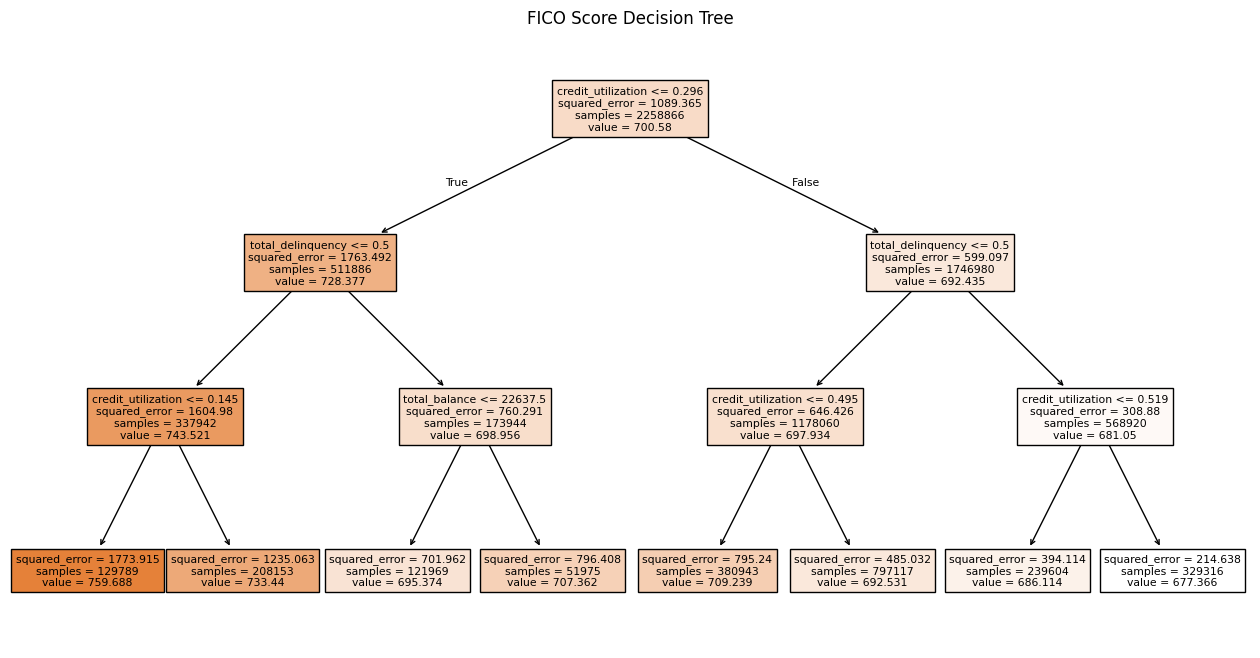

In [9]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

def train_decision_tree(csv_path: str):
    df = pd.read_csv(csv_path)
    features = ['credit_utilization', 'credit_history_years', 'total_delinquency',
                'recent_inquiries', 'credit_mix', 'total_balance']
    X = df[features]
    y = df['fico_score']

    tree_model = DecisionTreeRegressor(max_depth=3)
    tree_model.fit(X, y)

    plt.figure(figsize=(16, 8))
    plot_tree(tree_model, feature_names=features, filled=True)
    plt.title("FICO Score Decision Tree")
    plt.show()
train_decision_tree("../data/processed/accepted_cleaned.csv")